# Song lyrics exploration - Part 4: Network graphs

[Network graphs](https://en.wikipedia.org/wiki/Graph_(discrete_mathematics))
are used to visualize associations between elements of a dataset.
In this case, they can be used to show heavy metal bands with similar lyrics or genre tags.
This gives us another way to see if there are correlations between lyrical content and genre affiliation.

[The network graphs produced here can be viewed by clicking here](https://metal-lyrics-network-graph.herokuapp.com/)

We can treat bands as nodes in a graph and define edges according to what we're interested in:
* When visualizing genre association, connect two nodes with an edge if they share a genre tag in common.
* When visualizing lyrical similarity, connect two nodes with an edge if their vocabularies share many words in common.
  Similiarity can be quantified by cosine similarity between TF-IDF vectors,
  so we set a minimum cosine similarity for two nodes to be connected.

To distinguish between nodes, we can likewise cluster them by attribute,
using [K-means clustering](https://en.wikipedia.org/wiki/K-means_clustering).
The idea will be to label each node according to a group whose centroid it is nearest to.
* For genre clustering, we create a feature vector for each genre, and perform K-means over this genre space.
* For vocabulary clustering, we create a Tf-Idf vectorization as before.

In both cases, since the parameter space is rather large (a thousand words for lyrical clustering
and some tens of genres for genre clustering),
dimensionality reduction is required for efficient clustering.
[Truncated single-value decomposition](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)
(SVD) is preferred over [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis)
(PCA) here due to the sparsity of the feature matrices.

This analysis is applied to the full dataset, but for visualization purposes only the top-350 bands
with over 2,500 lyrics are shown in the final product, to preserve consistency with the
[feature plots dashboard](https://metal-lyrics-feature-plots.herokuapp.com/).

## Imports

In [68]:
import os
import numpy as np
import pandas as pd

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score

import sys
sys.path.append('../scripts/')

import lyrics_utils as utils

In [72]:
import matplotlib.pyplot as plt

## Data pre-processing

In [4]:
def tokenizer(s):
    return [word for word in s.split() if len(word) >= 4]


def clean_words(words, minlen=4):
    stop_words = stopwords.words('english')
    words = [w for w in words if (w not in stop_words) and (len(w) >= minlen)]
    return words

In [484]:
df = utils.load_bands('../bands-1pct.csv')
df = utils.get_band_stats(df)
df_short = utils.get_band_words(df, num_words=2500, num_bands=350)
names_short = df_short['name'].values
names = df['name'].values
df['clean_words'] = df['words'].apply(clean_words)

## Graph nodes

#### Vocabulary clustering

The corpus of band lyrics is vectorized using the scikit-learn `TfidfVectorizer`, reduced with `TruncatedSVD`, and fit to K-means.
The choice of $k=5$ clusters is discussed below.
A convenient benefit of K-means is that we usually end up with fairly even clusters.

In [495]:
vectorizer = TfidfVectorizer(
    stop_words=stopwords.words('english'),
    tokenizer=tokenizer,
    min_df=0.01,
    max_df=0.9,
    max_features=1000,
    sublinear_tf=False,
)
corpus = list(df['clean_words'].apply(lambda x: ' '.join(x)))
X = vectorizer.fit_transform(corpus)
vocab_svd = TruncatedSVD(n_components=2, random_state=0)
X_svd = vocab_svd.fit_transform(X)
vocab_kmeans = KMeans(n_clusters=5, random_state=0).fit(X_svd)
vocab_labels = vocab_kmeans.labels_
print("Lyrics clustering results:")
for i in sorted(set(vocab_labels)):
    print(f"{i}: {sum(vocab_labels == i) / len(vocab_labels) * 100:.1f}%")

Lyrics clustering results:
0: 22.4%
1: 19.9%
2: 18.6%
3: 21.1%
4: 18.1%


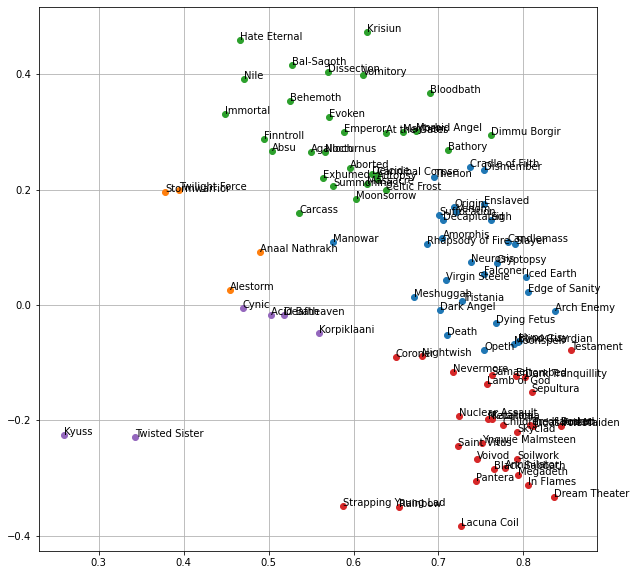

In [581]:
plt.figure(figsize=(10, 10))
for i in range(vocab_kmeans.n_clusters):
    cluster_idx = np.where(vocab_labels == i)[0]
    # for more visible plotting, just grab bands in the shortened list, and only the first 30
    cluster_idx = np.array([idx for idx in cluster_idx if df.name[idx] in names_short], dtype=int)
    cluster_idx = cluster_idx[:30]
    # plot x and y values in the reduced parameter space
    x, y = X_svd[cluster_idx].T
    plt.plot(x, y, 'o')
    for j in range(len(cluster_idx)):
        plt.text(x[j], y[j], names[cluster_idx][j])
plt.grid()
plt.show()

At this point it's hard to see if this has been effective at all.
Thankfully we can use [Gephi](https://gephi.org/) to better visualize the clustered data,
complete with the edges and color-coding.
All of the cluster labels node connections generated in this notebook are exported for processing in Gephi,
resulting in the final network graphs.

#### Choosing 'k' for K-means

Deciding on $k$, the number of clusters, is up to us and can depend on the task at hand.
Here I combine two possible ways of choosing $k$:
* Compute the sum of squared errors (SSE),
  which is simply the Euclidean distance between each point and its corresponding cluster center.
  You can't simply look for a minimum here, since the higher $k$ is, the lower WSS becomes.
  However, you can look for an "elbow" in the curve, beyond which further improvement is small.
* Maximize the [silhouette score](https://en.wikipedia.org/wiki/Silhouette_(clustering)),
  which measures how similar each point in a cluster is to each other point in the cluster,
  compared to its closeness to points in the nearest neighboring cluster.
  A higher silhouette score is better, but it may not be useful if the maximum score corresponds
  to a trivially small $k$, as is the case here.

I combine these two by dividing the silhouette score by the SSE, and look for the earliest (smallest $k$)
local maximum in the metric. Since SSE drops of roughly exponentially, I divide specifically by $log(SSE)$.
This gives a curve that reaches its first local maximum at $k=5$.
Really it's $k=2$ but I want to skip that trivial option.

In [282]:
def test_k_values(points, krange):
    n_k = len(krange)
    sse = np.zeros(n_k)
    sil = np.zeros(n_k)
    lab = np.zeros((n_k, len(points)))
    for i, k in enumerate(krange):
        kmeans = KMeans(n_clusters=k, random_state=0).fit(points)
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_
        for j, p in enumerate(points):
            center = centroids[labels[j]]
            sse[i] += (p[0] - center[0])**2 + (p[1] - center[1])**2
        sil[i] = silhouette_score(points, labels, metric='euclidean')
        lab[i, :] = labels
    return sse, sil, lab

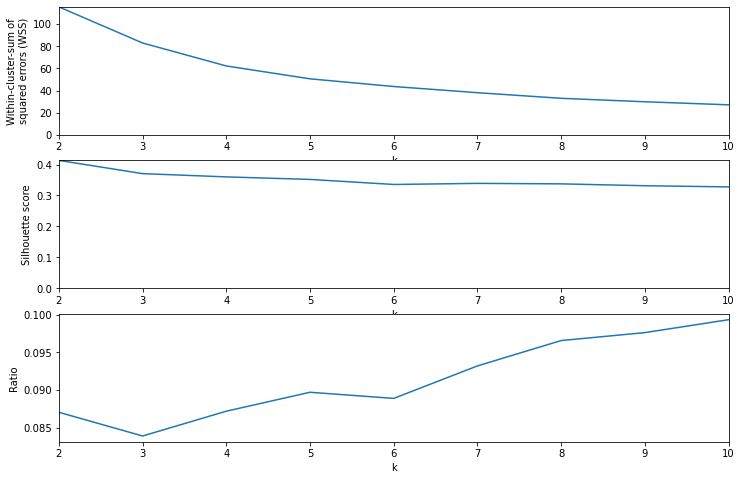

In [283]:
kmin = 2
kmax = 10
krange = np.arange(kmin, kmax + 1)
sse, sil, lab = test_k_values(X_svd, krange)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))

ax1.plot(krange, sse)
ax1.set_xlim(kmin, kmax)
ax1.set_ylim(0, wss.max())
ax1.set_xlabel("k")
ax1.set_ylabel("Within-cluster-sum of\nsquared errors (WSS)")

ax2.plot(krange, sil)
ax2.set_xlim(kmin, kmax)
ax2.set_ylim(0, sil.max())
ax2.set_xlabel("k")
ax2.set_ylabel("Silhouette score")

ax3.plot(krange, sil / np.log(wss))
ax3.set_xlim(kmin, kmax)
ax3.set_xlabel("k")
ax3.set_ylabel("Ratio")

plt.show()

#### Genre clustering

Similar process for genres, but in this case the genre columns (binary values)
are treated as the feature matrix.
The value of $k=6$ is determined in a similar way.

In [488]:
genre_cols = [c for c in df.columns if 'genre_' in c]
Y = df[genre_cols].values
Y_svd = TruncatedSVD(n_components=2, random_state=0).fit_transform(Y)
genre_kmeans = KMeans(n_clusters=6, random_state=0).fit(Y_svd)
genre_labels = genre_kmeans.labels_
print("Genre clustering results:")
for i in sorted(set(genre_labels)):
    print(f"{i}: {sum(genre_labels == i) / len(genre_labels) * 100:.1f}%")
for i in sorted(set(genre_labels)):
    center_genres = sorted(zip(genre_cols, Y[genre_labels == i].mean(axis=0)), key=lambda x: -x[1])
    print(", ".join([f"{genre.split('_')[1]} {value:.2f}" for genre, value in center_genres if value > 0.1]))

Genre clustering results:
0: 21.7%
1: 10.9%
2: 16.9%
3: 5.9%
4: 19.8%
5: 24.8%
thrash 0.39, progressive 0.37, doom 0.29, power 0.15
death 1.00, doom 0.40, thrash 0.39, progressive 0.26
black 1.00
black 1.00, death 1.00, symphonic 0.12
death 1.00
power 0.40, heavy 0.29, symphonic 0.11


#### Choosing 'k'

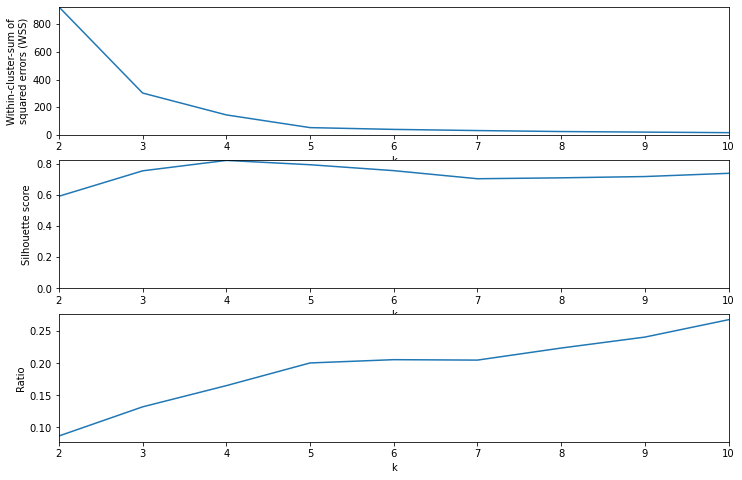

In [489]:
kmin = 2
kmax = 10
krange = np.arange(kmin, kmax + 1)
wss, sil, lab = test_k_values(Y_pca, krange)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))

ax1.plot(krange, wss)
ax1.set_xlim(kmin, kmax)
ax1.set_ylim(0, wss.max())
ax1.set_xlabel("k")
ax1.set_ylabel("Within-cluster-sum of\nsquared errors (WSS)")

ax2.plot(krange, sil)
ax2.set_xlim(kmin, kmax)
ax2.set_ylim(0, sil.max())
ax2.set_xlabel("k")
ax2.set_ylabel("Silhouette score")

ax3.plot(krange, sil / np.log(wss))
ax3.set_xlim(kmin, kmax)
ax3.set_xlabel("k")
ax3.set_ylabel("Ratio")

plt.show()

#### Create labeled nodes

For handling graph nodes, Gephi just needs a table of numerical `id` values, string `label` values,
and any number of integer columns representing categories for coloring the graph.
In this case I include the genre and vocabulary clusters as categorical columns.

In [463]:
nodes = pd.DataFrame({'id': range(1, len(names) + 1), 'label': names, 'genre': genre_labels, 'lyrics': vocab_labels})
nodes = nodes[nodes.label.isin(names_short)].reset_index(drop=True)
nodes

,id,label,genre,lyrics
0,1,Amorphis,2,0
1,2,Blind Guardian,3,0
2,3,Iced Earth,3,0
3,4,Katatonia,2,3
4,5,Entombed,2,3
...,...,...,...,...
195,3217,Whitechapel,5,3
196,3315,Fleshgod Apocalypse,2,0
197,3328,Alestorm,3,1
198,3682,Ghost,0,2


## Edges

#### Vocabulary similary

We can quantify similarity between two bands' lyrics by measuring the cosine similarity
between their respective Tf-Idf vectors.
This is a pretty efficient calculation given the large vector space being used.
The threshold for drawing an edge between two nodes depends on the cosine similarities
of each node to all other nodes.
For instance, to determine if nodes $i$ and $j$ will be connected,
the cosine similiarity between them, $C_{ij}$, must exceed the mean of $C_{ik}$ for all $k \neq i$
plus two standard deviations of $C_{ik}$.
The factor of two standard deviations is chosen to get roughly the same ratio of edges to nodes
as I get in the genre similarity method further below.

In [464]:
cos_matrix = cosine_similarity(X)
cos_vals = cos_matrix[cos_matrix < 1]
vocab_edges_dict = {'Source': [], 'Target': []}
for i, name in enumerate(names):
    row = cos_matrix[i, :]
    vals = row[row < 1]
    thresh = vals.mean() + 2 * vals.std()
    idx = np.where(row > thresh)[0]
    idx = idx[idx != i]
    for j in idx:
        vocab_edges_dict['Source'].append(i + 1)
        vocab_edges_dict['Target'].append(j + 1)
vocab_edges = pd.DataFrame(vocab_edges_dict)
vocab_edges = vocab_edges[vocab_edges.Source.isin(nodes.id) & vocab_edges.Target.isin(nodes.id)]
vocab_edges

,Source,Target
0,1,2
1,1,4
2,1,19
3,1,20
4,1,24
...,...,...
297923,3722,571
297924,3722,593
297943,3722,1679
297951,3722,2225


54.06


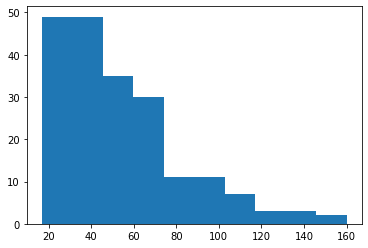

In [465]:
num_edges = np.zeros(len(nodes))
for i, row in nodes.iterrows():
    targets = vocab_edges.loc[vocab_edges.Source == row.id, 'Target'].values
    sources = vocab_edges.loc[vocab_edges.Target == row.id, 'Source'].values
    num_edges[i] = len(targets) + len(sources)

print(num_edges.mean())

plt.hist(num_edges)
plt.show()

In [466]:
ids_with_edges = set(vocab_edges.Source).union(set(vocab_edges.Target))
labels_with_edges = [nodes.loc[nodes.id == id_, 'label'].iloc[0] for id_ in ids_with_edges]
print(len(labels_with_edges))
print(sorted(labels_with_edges))

200
['Aborted', 'Accept', 'Agalloch', 'Akercocke', 'Alestorm', 'Amon Amarth', 'Amorphis', 'Anathema', 'Angra', 'Annihilator', 'Anthrax', 'Anvil', 'Arch Enemy', 'Arsis', 'Artillery', 'Asphyx', 'At the Gates', 'Atheist', 'Autopsy', 'Avantasia', 'Bathory', 'Behemoth', 'Belphegor', 'Black Sabbath', 'Blind Guardian', 'Bloodbath', 'Bolt Thrower', 'Borknagar', 'Candlemass', 'Cannibal Corpse', 'Carach Angren', 'Carcass', 'Cattle Decapitation', 'Celtic Frost', 'Children of Bodom', 'Corrosion of Conformity', 'Cradle of Filth', 'Cryptopsy', 'Dark Angel', 'Dark Funeral', 'Dark Tranquillity', 'Darkthrone', 'Deafheaven', 'Death', 'Death Angel', 'Deathspell Omega', 'Decapitated', 'Deicide', 'Destruction', 'DevilDriver', 'Dimmu Borgir', 'Dio', 'Dismember', 'Dissection', 'DragonForce', 'Dream Theater', 'Dying Fetus', 'Edge of Sanity', 'Edguy', 'Electric Wizard', 'Eluveitie', 'Elvenking', 'Emperor', 'Ensiferum', 'Enslaved', 'Entombed', 'Epica', 'Evergrey', 'Exodus', 'Faith No More', 'Falconer', 'Fates W

#### Genre similarity

This is simple: draw an edge between two nodes if they share a genre tag in common.

In [468]:
genre_edges_dict = {'Source': [], 'Target': []}
for i, row1 in nodes.iterrows():
    id_i = row1.id
    for j, row2 in nodes[nodes.id > id_i].iterrows():
        id_j = row2.id
        if np.dot(Y[id_i - 1], Y[id_j - 1]) > 0:
            genre_edges_dict['Source'].append(id_i)
            genre_edges_dict['Target'].append(id_j)
genre_edges = pd.DataFrame(genre_edges_dict)
genre_edges

,Source,Target
0,1,4
1,1,5
2,1,6
3,1,8
4,1,9
...,...,...
5625,3024,3116
5626,3024,3175
5627,3024,3217
5628,3024,3315


56.3


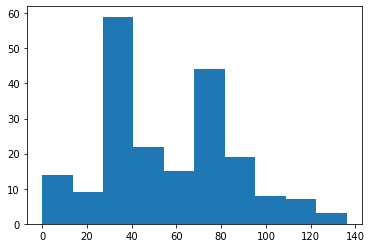

In [469]:
num_genre_edges = np.zeros(len(nodes))
for i, row in nodes.iterrows():
    targets = genre_edges.loc[genre_edges.Source == row.id, 'Target'].values
    sources = genre_edges.loc[genre_edges.Target == row.id, 'Source'].values
    num_genre_edges[i] = len(targets) + len(sources)

print(num_genre_edges.mean())

plt.hist(num_genre_edges)
plt.show()

In [470]:
ids_with_genre_edges = set(genre_edges.Source).union(set(genre_edges.Target))
labels_with_genre_edges = [nodes.loc[nodes.id == id_, 'label'].iloc[0] for id_ in ids_with_genre_edges]
print(len(labels_with_genre_edges))
print(sorted(labels_with_genre_edges))

196
['Aborted', 'Accept', 'Agalloch', 'Akercocke', 'Alestorm', 'Amon Amarth', 'Amorphis', 'Anathema', 'Angra', 'Annihilator', 'Anthrax', 'Anvil', 'Arch Enemy', 'Arsis', 'Artillery', 'Asphyx', 'At the Gates', 'Atheist', 'Autopsy', 'Avantasia', 'Bathory', 'Behemoth', 'Belphegor', 'Black Sabbath', 'Blind Guardian', 'Bloodbath', 'Bolt Thrower', 'Borknagar', 'Candlemass', 'Cannibal Corpse', 'Carach Angren', 'Carcass', 'Cattle Decapitation', 'Celtic Frost', 'Children of Bodom', 'Cradle of Filth', 'Cryptopsy', 'Dark Angel', 'Dark Funeral', 'Dark Tranquillity', 'Darkthrone', 'Death', 'Death Angel', 'Deathspell Omega', 'Decapitated', 'Deicide', 'Destruction', 'DevilDriver', 'Dimmu Borgir', 'Dio', 'Dismember', 'Dissection', 'DragonForce', 'Dream Theater', 'Dying Fetus', 'Edge of Sanity', 'Edguy', 'Electric Wizard', 'Eluveitie', 'Elvenking', 'Emperor', 'Ensiferum', 'Enslaved', 'Entombed', 'Epica', 'Evergrey', 'Exodus', 'Falconer', 'Fates Warning', 'Fear Factory', 'Firewind', 'Fleshgod Apocalypse'